In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

<b><font size="6" color="#009e84"> ch08. 트랜스포머로 영화평 감상 분석</font></b>

- 'Long Short-Term Memory'
- imdb 사이트의 5만개 영화 감상평 : Train/test - 타겟변수:부정/긍정

# 1. 패키지 import

In [1]:
import numpy as np
import pandas as pd
import os

from tensorflow.keras.datasets import imdb # imdb 사이트의 영화감상평 data
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, save_model

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

from time import time # 유닉스time을 계산하기 위해

# 2. 하이퍼파라미터 설정

- 하이퍼파라미터를 바꾸면 모델의 정확도나 속도가 차이남

In [2]:
# 파라미터 설정. 여기서 다 할당해두고 학습결과를 보면서 조절할거라서. 이건 보통 대문자로 많이 씀

MY_WORDS  = 20000 # imdb 데이터 안의 단어 수.
MY_LENGTH = 150    # 독립변수 차원(영화평 단어수를 80개로 맞출 예정)-가장 좋은건 영화평 평균길이
MY_EMBED  = 64    # Embedding 결과 차원
MY_HIDDEN = 128    # LSTM의 units 수
MY_EPOCH  = 20    # fit 반복학습수
MY_BATCH  = 200   # batchsize(fit할때, 매번 가져오는 데이터 수)

# 3. 데이터 불러오기

In [4]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=MY_WORDS)

In [5]:
print('학습용 독립변수 모양 :', X_train.shape)
print('학습용 타겟변수 모양 :', y_train.shape)
print('학습용 독립변수 타입 :', type(X_train))
print('학습용 독립변수 샘플 :', X_train[0])
print('학습용 타겟변수 샘플(0:부정/1:긍정) :', y_train)
print('테스트용 독립변수 모양 :', X_test.shape)
print('테스트용 타겟변수 모양 :', y_test.shape)

학습용 독립변수 모양 : (25000,)
학습용 타겟변수 모양 : (25000,)
학습용 독립변수 타입 : <class 'numpy.ndarray'>
학습용 독립변수 샘플 : [2, 2, 2, 2, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 36, 256, 2, 2, 100, 43, 838, 112, 50, 670, 2, 2, 35, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 39, 2, 172, 4536, 1111, 2, 546, 38, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 43, 530, 38, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 19193, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 5244, 2, 480, 66, 3785, 33, 2, 130, 2, 2, 38, 619, 2, 2, 124, 51, 36, 135, 48, 2, 1415, 33, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 10311, 2, 2, 107, 117, 5952, 2, 256, 2, 2, 2, 3766, 2, 723, 36, 71, 43, 530, 476, 2, 400, 317, 46, 2, 2, 12118, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 32, 2071, 56, 2, 141, 2, 194, 7486, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 30, 5535, 2, 51, 36, 2, 224, 92, 2, 104, 2, 226, 65, 2, 38, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 32, 2, 2, 5345, 2, 178, 32]
학

In [6]:
# 부/긍정 갯수

print(pd.Series(y_train).value_counts(normalize=True))
print(pd.Series(y_test).value_counts())

1    0.5
0    0.5
dtype: float64
0    12500
1    12500
dtype: int64


In [7]:
# 긍정 갯수

print('학습데이터의 긍정 갯수 :', y_train.sum())
print('테스트데이터의 긍정 갯수 :', y_test.sum())

학습데이터의 긍정 갯수 : 12500
테스트데이터의 긍정 갯수 : 12500


# 4. 문자단어 → 정수

In [5]:
word_to_id = imdb.get_word_index() # 단어(word):정수(id) 빈도가 높은 단어는 앞
print(len(word_to_id))
print(word_to_id['movie']) # 자주 나와서 숫자가 앞
print(word_to_id['film'])
print(word_to_id['the'])
print(word_to_id['fawn']) # 자주 나오지 않아서 숫자가 뒤

# 정수 → 문자단어
id_to_word = {} # 정수(id):단어(word)
for key, value in word_to_id.items():
    id_to_word[value] = key
print(id_to_word[17])
print(id_to_word.get(19))
print(id_to_word.get(16))

# SKIP_TOP값을 고민하기 위해 최빈단어(현재 SKIP_TOP값 20)
print([id_to_word[i] for i in range(1, 48)])

88584
17
19
1
34701
movie
film
with
['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'all', 'at', 'by', 'an', 'they', 'who', 'so', 'from', 'like', 'her', 'or', 'just', 'about', "it's", 'out', 'has', 'if', 'some', 'there']


In [6]:
msg = 'What a wonderful moviedsfsd'
msg = msg.lower().split() # word_to_id에 무조건 소문자가 들어가있어서
print(msg)

# 0 : padding처리
# 1 : 리뷰의 시작을 알리는 숫자 
# 2 : MY_WORDS(10000) 이내에 들어가지 않는 단어

data = [1] + [word_to_id.get(m, -1) + 3  for m in msg] # 지금 moviedsfsd는 없어서 None으로 나오는데 그걸 -1으로 처리. 그리고 +3 을 해서 2로 나오는것
print('원 후기 내용 :', msg)
print('encoded된 내용(data)에 SKIP_TOP 처리 안할 경우 :', data)

print('SKIP_TOP 처리할 경우 :', data)
print('data 추정 :', ' '.join([id_to_word.get(d-3, '???') for d in data]) )

['what', 'a', 'wonderful', 'moviedsfsd']
원 후기 내용 : ['what', 'a', 'wonderful', 'moviedsfsd']
encoded된 내용(data)에 SKIP_TOP 처리 안할 경우 : [1, 51, 6, 389, 2]
SKIP_TOP 처리할 경우 : [1, 51, 6, 389, 2]
data 추정 : ??? what a wonderful ???


In [10]:
[id_to_word.get(d-3, '???') for d in data] # 1은 시작 숫자다보니 -3하면 -2라서 ???

['???', 'what', '???', 'wonderful', '???']

# 5. 숫자 영화평 → 자연어 영화평 함수

[`AI설명`]

IMDB 인덱스 구조
IMDB 데이터셋은 단어별로 이런 식으로 번호를 매긴다.
- 0: 패딩용 토큰 (pad)
- 1: 문장 시작 토큰 (start_char)
- 2: OOV 토큰, 사전에 없거나 자른 단어 (oov_char)

3번부터: 실제 단어들이 빈도순으로 매겨진 인덱스

반면 imdb.get_word_index()로 가져오는 word_to_index는 “단어 → 원래 인덱스” 매핑인데, 여기서의 인덱스는 1부터 시작하는 “원래 단어 랭킹”이고, 아직 0,1,2 같은 특수 토큰을 위한 오프셋이 적용되지 않은 값이다.

In [7]:
def decoding(review_nums):
    decoded = [] # 숫자를 단어로 해석한 내용 append
    for num in review_nums:
        word = id_to_word.get(num - 3, '???')
        decoded.append(word)
    print(' '.join(decoded))

In [8]:
print(X_train[0])
print(decoding(X_train[0]), y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
??? this film was just brilliant casting locatio

# 6. 영화평 학습용 데이터

In [9]:
def show_length():
    print('첫 20개 영화평 길이')
#     for i in range(11):
#         print(f'{i}번째 길이 :{len(X_train[i])}')
    print([len(x) for x in X_train[:21]])
        
show_length()

첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [14]:
print('pad_sequence 작업전')
show_length()

pad_sequence 작업전
첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [15]:
# X_train후기 중 가장 긴 단어수, 가장 짧은 단어수

max([len(x) for x in X_train]), min([len(x) for x in X_train])

(2494, 11)

In [16]:
# 영화평 길이 평균

np.array([len(x) for x in X_train]).mean()

238.71364

# 7. 모든 영화평의 길이를 동일하게(MY_LENGTH만큼)

In [10]:
# 한번만 실행해야함. train과 test는 자르는 위치를 동일하게 둬야함. train 앞을 자르면 test도 앞을 잘라야함.
X_train = pad_sequences(X_train,
                        maxlen=MY_LENGTH,
#                         truncating='post',  # 80단어 이상일 경우 어디를 자를지 여부
                        truncating='pre',
#                         padding='post',     # 단어가 짧은 경우 zero를 붙임
                        padding='pre', 
                        )
X_test = pad_sequences(X_test,
                       maxlen=MY_LENGTH,
#                        truncating='post',  # 80단어 이상일 경우 어디를 자를지 여부
                       truncating='pre',
#                        padding='post',     # 단어가 짧은 경우 zero를 붙임
                       padding='pre', 
                       )
show_length()

첫 20개 영화평 길이
[150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150]


# 8. 최종 데이터 shape 확인

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 150), (25000,), (25000, 150), (25000,))

In [19]:
decoding(X_train[0])

??? ??? just brilliant so much ??? ??? bought ??? ??? ??? soon ??? ??? ??? released ??? retail ??? would recommend ??? ??? everyone ??? watch ??? ??? fly fishing ??? amazing really cried at ??? end ??? ??? so sad ??? ??? know what they say if ??? cry at ??? ??? ??? must ??? been good ??? ??? definitely ??? also congratulations ??? ??? two little boy's ??? played ??? ??? ??? norman ??? paul they were just brilliant children ??? often left out ??? ??? praising list ??? think because ??? stars ??? play them all grown up ??? such ??? big profile ??? ??? whole ??? ??? these children ??? amazing ??? should be praised ??? what they ??? done don't ??? think ??? whole story ??? so lovely because ??? ??? true ??? ??? someone's life after all ??? ??? shared ??? us all


# 9. 모델 생성 및 구현

## 9.1 LSTM

In [20]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS,
                    output_dim=MY_EMBED,
                    input_length=MY_LENGTH))
model.add(LSTM(units=MY_HIDDEN,
               dropout=0.5, # 0.1~0.6 각 스텝마다 LSTM셀로 들어가는 연결 30%를 0으로 변경
               recurrent_dropout=0.3 # 0.1~0.3 이전 LSTM에서 다음 LSTM셀로 가는 연결 20% 0으로
               # input_shape=(MY_LENGTH, MY_EMBED), 굳이 안써도 됨
               # kernel_initializer='he_normal', # 입력 가중치 초기화. 밑에서 들어오는 가중치
               # recurrent_initializer='orthogonal', # 순환 가중치 초기화. 옆에서 들어오는 가중치
               ))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 64)           1280000   
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


## 9.2 트랜스포머 (인코딩부분 모델구현)

In [14]:
from tensorflow import range
from tensorflow.keras.layers import Input, Dropout, MultiHeadAttention, add, BatchNormalization, GlobalAvgPool1D, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential

In [17]:
# 입력층, 임베딩층
INPUTS = Input(shape=(MY_LENGTH,))
INPUT_EMBEDDING = Embedding(input_dim=MY_WORDS,
                            output_dim=MY_EMBED)(INPUTS)

# Positional Encoding
POSITTIONS = range(start=0,
                   limit=MY_LENGTH)

POS_ENCODING = Embedding(input_dim=MY_WORDS,
                         output_dim=MY_EMBED)(POSITTIONS)

POS_ENC_OUTPUT = POS_ENCODING + INPUT_EMBEDDING

# Multi-Head Attention
ATTENTION_OUTPUT = MultiHeadAttention(num_heads=3,
                                      key_dim=MY_EMBED)(POS_ENC_OUTPUT, POS_ENC_OUTPUT)

X = add([POS_ENC_OUTPUT, ATTENTION_OUTPUT])
X = BatchNormalization()(X)

# FFN(Feed Forword Network)
FFN = Sequential([Dense(MY_HIDDEN, activation='relu'),
                  Dense(MY_EMBED, activation='relu')])(X)
X = add([FFN, X])
X = BatchNormalization()(X)

# 하나의 벡터로 하여 Dense에 보냄
X = GlobalAvgPool1D()(X) # 2차원 → 1차원
X = Dropout(0.1)(X)
X = Dense(units=MY_HIDDEN, activation='relu')(X)
X = Dropout(0.1)(X)

OUTPUTS = Dense(units=2, # 부정/긍정 그룹 (다중분류방식)
                activation='softmax')(X)

# 모델생성
model = Model(inputs=INPUTS, outputs=OUTPUTS)

# 10. 학습환경 설정 및 학습하기

In [18]:
model.compile(loss='sparse_categorical_crossentropy', # 다중분류
              optimizer='adam',
              metrics=['accuracy'])

start = time() # 70.1.1 ~ 이 시점까지의 초수 (%%time은 주피터노트북에서만 쓸 수 있어서)

earlyStopping = EarlyStopping(patience=5)
model_save_folder = './model/imdb/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)
file = model_save_folder + 'imdb_v2.10_skip20length150-val{val_accuracy:.3f}.h5'

checkpoint = ModelCheckpoint(filepath=file,
                             save_best_only=True,
                             mode='max')

hist = model.fit(X_train, y_train,
                 epochs=MY_EPOCH,
                 batch_size=MY_BATCH,
                 validation_split=0.2,
                 verbose=1,
                 callbacks=[earlyStopping, checkpoint])

end = time() # 70.1.1 ~ 이 시점까지의 초수
print('총 fit 시간 : {:.5f}'.format(end-start))

Epoch 1/20
100/100 [==============================] - 38s 373ms/step - loss: 0.4180 - accuracy: 0.8016 - val_loss: 0.6297 - val_accuracy: 0.5392
Epoch 2/20
100/100 [==============================] - 40s 401ms/step - loss: 0.1886 - accuracy: 0.9262 - val_loss: 0.6303 - val_accuracy: 0.5468
Epoch 3/20
100/100 [==============================] - 40s 399ms/step - loss: 0.1100 - accuracy: 0.9590 - val_loss: 0.4735 - val_accuracy: 0.7502
Epoch 4/20
100/100 [==============================] - 40s 398ms/step - loss: 0.0698 - accuracy: 0.9740 - val_loss: 0.3668 - val_accuracy: 0.8384
Epoch 5/20
100/100 [==============================] - 41s 406ms/step - loss: 0.0538 - accuracy: 0.9800 - val_loss: 0.4683 - val_accuracy: 0.8330
Epoch 6/20
100/100 [==============================] - 41s 407ms/step - loss: 0.0398 - accuracy: 0.9844 - val_loss: 0.6495 - val_accuracy: 0.8318
Epoch 7/20
100/100 [==============================] - 41s 412ms/step - loss: 0.0358 - accuracy: 0.9866 - val_loss: 0.7343 - val_ac

# 11. 모델 평가

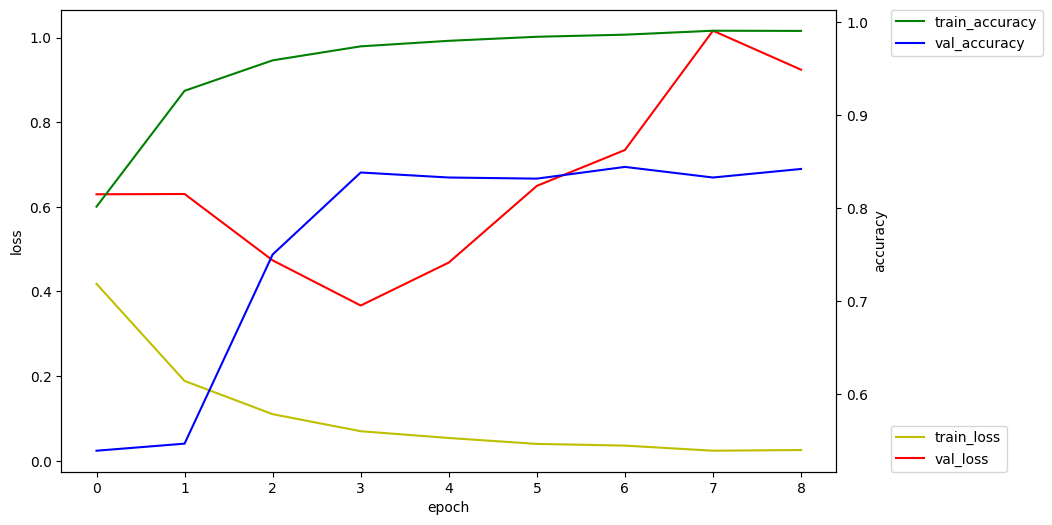

In [19]:
# 학습과정 표시하기

import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')

acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(bbox_to_anchor=(1.07, 0.1), loc=2, borderaxespad=0.)
acc_ax.legend(bbox_to_anchor=(1.07, 1), loc=2, borderaxespad=0.)
plt.show()

In [20]:
# 테스트 데이터로 평가

loss, acc = model.evaluate(X_test, y_test)
print('test의 데이터 정확도 :', acc)

782/782 [==============================] - 20s 25ms/step - loss: 1.0266 - accuracy: 0.8204
test의 데이터 정확도 : 0.8204399943351746


In [24]:
# 모델 저장

model.save('model/imdb_v2.10_skip20length200_acc.h5')

In [22]:
# 혼동행렬(교차표, 평균성능지표)
# y_test : 실제값

pred = model.predict(X_test)
y_hat = (pred>0.5).astype(int)
y_hat

782/782 [==============================] - 19s 25ms/step


array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [0, 1]])

In [24]:
y_test.shape, y_hat.shape

((25000,), (25000, 2))

In [25]:
# 실제값과 예측값의 차원이 같지 않아도 됨

confusion_matrix(y_test, y_hat)

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [23]:
# 실제값과 예측값의 차원이 1차원

ctab = pd.crosstab(y_test, y_hat.reshape(-1), rownames=['실제값'], colnames=['예측값'])
ctab

ValueError: All arrays must be of the same length

In [29]:
ctab['0확률'] = [ctab.iloc[0,0]/25000*100, ctab.iloc[1,0]/25000*100]
ctab['1확률'] = [ctab.iloc[0,1]/25000*100, ctab.iloc[1,1]/25000*100]
ctab

예측값,0,1,0확률,1확률
실제값,,,,
0,11087,1413,44.348,5.652
1,2914,9586,11.656,38.344


In [30]:
# accuracy, precision, recall, f1_score

print('acc :', acc)
print('precision :', precision_score(y_test, y_hat))
print('recall :', recall_score(y_test, y_hat))
print('f1 score :', f1_score(y_test, y_hat))

acc : 0.8269199728965759
precision : 0.8715337757977998
recall : 0.76688
f1 score : 0.8158645048725478


# 12. 모델 사용하기

In [31]:
review = '''
This movie was an absolute thrill from start to finish! The plot kept me on the edge of my seat with unexpected twists and turns. 
The characters were so relatable and expertly portrayed, making me care deeply about their journeys. 
The visuals were stunning and perfectly complemented the intense soundtrack. I laughed, I cried, and I was completely immersed in every scene. 
It's a must-watch for anyone who loves a good mix of action, drama, and emotion. Highly recommended!:)
'''.lower()
review

"\nthis movie was an absolute thrill from start to finish! the plot kept me on the edge of my seat with unexpected twists and turns. \nthe characters were so relatable and expertly portrayed, making me care deeply about their journeys. \nthe visuals were stunning and perfectly complemented the intense soundtrack. i laughed, i cried, and i was completely immersed in every scene. \nit's a must-watch for anyone who loves a good mix of action, drama, and emotion. highly recommended!:)\n"

In [32]:
import re

In [33]:
review = re.sub('[^a-zA-Z0-9\s]', ' ', review) # 저 안에 안들어간것은 스페이스로 바꿔
review = review.split()
print(review)

['this', 'movie', 'was', 'an', 'absolute', 'thrill', 'from', 'start', 'to', 'finish', 'the', 'plot', 'kept', 'me', 'on', 'the', 'edge', 'of', 'my', 'seat', 'with', 'unexpected', 'twists', 'and', 'turns', 'the', 'characters', 'were', 'so', 'relatable', 'and', 'expertly', 'portrayed', 'making', 'me', 'care', 'deeply', 'about', 'their', 'journeys', 'the', 'visuals', 'were', 'stunning', 'and', 'perfectly', 'complemented', 'the', 'intense', 'soundtrack', 'i', 'laughed', 'i', 'cried', 'and', 'i', 'was', 'completely', 'immersed', 'in', 'every', 'scene', 'it', 's', 'a', 'must', 'watch', 'for', 'anyone', 'who', 'loves', 'a', 'good', 'mix', 'of', 'action', 'drama', 'and', 'emotion', 'highly', 'recommended']


In [34]:
encoded = [1] + [word_to_id.get(r, -1)+3 for r in review]
print(encoded)

[1, 14, 20, 16, 35, 1557, 3974, 39, 380, 8, 1363, 4, 114, 828, 72, 23, 4, 1289, 7, 61, 2224, 19, 2076, 1299, 5, 505, 4, 105, 71, 38, 14213, 5, 6234, 1000, 231, 72, 459, 1685, 44, 68, 14069, 4, 2057, 71, 1380, 5, 950, 21288, 4, 1596, 816, 13, 1498, 13, 3785, 5, 13, 16, 340, 9532, 11, 175, 136, 12, 590, 6, 215, 106, 18, 259, 37, 1388, 6, 52, 1493, 7, 206, 453, 5, 1426, 545, 1178]


In [35]:
# SKIP_TOP 사용시 

encoded = [2 if (e<=30)|(e>20000) else e for e in encoded] # e가 20보다 작거나 같고 1000초과일경우 2로 표시하고 아니면 e로 해라
print(encoded, len(encoded))

[2, 2, 2, 2, 35, 1557, 3974, 39, 380, 2, 1363, 2, 114, 828, 72, 2, 2, 1289, 2, 61, 2224, 2, 2076, 1299, 2, 505, 2, 105, 71, 38, 14213, 2, 6234, 1000, 231, 72, 459, 1685, 44, 68, 14069, 2, 2057, 71, 1380, 2, 950, 2, 2, 1596, 816, 2, 1498, 2, 3785, 2, 2, 2, 340, 9532, 2, 175, 136, 2, 590, 2, 215, 106, 2, 259, 37, 1388, 2, 52, 1493, 2, 206, 453, 2, 1426, 545, 1178] 82


In [36]:
input_data = pad_sequences([encoded],
                           maxlen=MY_LENGTH,
                           truncating='pre',
                           padding='pre', 
                           )
input_data

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     2,     2,     2,     2,
           35,  1557,  3974,    39,   380,     2,  1363,     2,   114,
          828,    72,     2,     2,  1289,     2,    61,  2224,     2,
         2076,  1299,     2,   505,     2,   105,    71,    38, 14213,
            2,  6234,  1000,   231,    72,   459,  1685,    44,    68,
        14069,     2,  2057,    71,  1380,     2,   950,     2,     2,
         1596,   816,     2,  1498,     2,  3785,     2,     2,     2,
      

In [37]:
(model.predict(input_data)).argmax(axis=1) # 전과 달리 >0.5를 붙이지 않는게 이중분류가 아니라서

1/1 [==============================] - 0s 21ms/step


array([[1]], dtype=int8)

In [38]:
review='''
This movie was a huge disappointment from beginning to end. 
The storyline was confusing and lacked any real direction, making it hard to stay engaged. 
The characters felt flat and unconvincing, with poor acting that made it difficult to care about their fates. 
The pacing was painfully slow, dragging on without any meaningful development:( 
Visual effects looked cheap and outdated, which only added to the overall frustration. 
The soundtrack was forgettable and didn’t fit the mood at all. Overall, it felt like a waste of time and money. 
I wouldn’t recommend this to anyone looking for quality entertainment.
'''.lower()
review = re.sub('[^a-zA-Z0-9\s]', ' ', review)
review = review.split()

encoded = [1] + [word_to_id.get(r, -1)+3 for r in review]
encoded = [e if (e>30) & (e<=20000) else 2 for e in encoded]
print(encoded, len(encoded))

[2, 2, 2, 2, 2, 666, 1387, 39, 454, 2, 130, 2, 769, 2, 1499, 2, 3674, 101, 147, 458, 231, 2, 254, 2, 789, 3953, 2, 105, 421, 1035, 2, 2631, 2, 338, 116, 2, 93, 2, 878, 2, 459, 44, 68, 13989, 2, 1794, 2, 2149, 550, 8056, 2, 209, 101, 3191, 943, 1114, 302, 610, 706, 2, 5903, 63, 64, 1283, 2, 2, 444, 4185, 2, 816, 2, 2441, 2, 15499, 830, 1183, 2, 1310, 33, 32, 444, 2, 421, 40, 2, 437, 2, 58, 2, 278, 2, 2, 830, 386, 2, 2, 259, 267, 2, 489, 722] 101


In [39]:
input_data = pad_sequences([encoded],
                           maxlen=MY_LENGTH,
                           truncating='pre',
                           padding='pre', 
                           )
input_data

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     2,     2,     2,     2,     2,
          666,  1387,    39,   454,     2,   130,     2,   769,     2,
         1499,     2,  3674,   101,   147,   458,   231,     2,   254,
            2,   789,  3953,     2,   105,   421,  1035,     2,  2631,
            2,   338,   116,     2,    93,     2,   878,     2,   459,
           44,    68, 13989,     2,  1794,     2,  2149,   550,  8056,
            2,   209,   101,  3191,   943,  1114,   302,   610,   706,
            2,  5903,    63,    64,  1283,     2,     2,   444,  4185,
            2,   816,     2,  2441,     2, 15499,   830,  1183,     2,
      

In [40]:
(model.predict(input_data) > 0.5).astype('int8')

1/1 [==============================] - 0s 21ms/step


array([[0]], dtype=int8)

In [45]:
model3 = load_model('model/imdb_v2.10_skip20length150-val0.859.h5')
loss, acc = model3.evaluate(X_test, y_test)
print('test의 데이터 정확도 :', acc)
print('test의 데이터 오차값 :', loss)

782/782 [==============================] - 14s 18ms/step - loss: 0.4771 - accuracy: 0.8476
test의 데이터 정확도 : 0.847599983215332
test의 데이터 오차값 : 0.47713807225227356
